# Introduction

- Recently, Arabic handwritten characters recognition has been an important area due to its applications in several fields. This work is focusing on the recognition part of handwritten Arabic characters recognition that face several challenges, including the unlimited variation in human handwriting and the large public databases. 

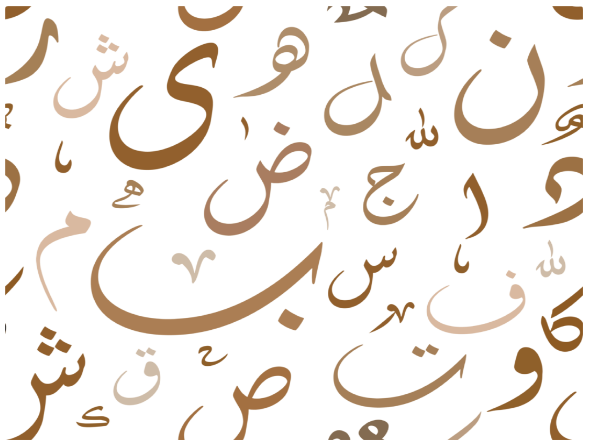

# Data overview

- The data-set is composed of 16,800 characters written by 60 participants, the age range is between 19 to 40 years, and 90% of participants are right-hand. Each participant wrote each character (from ’alef’ to ’yeh’) ten times on two forms as shown in Fig. 7(a) & 7(b). The forms were scanned at the resolution of 300 dpi. Each block is segmented automatically using Matlab 2016a to determining the coordinates for each block. The database is partitioned into two sets: a training set (13,440 characters to 480 images per class) and a test set (3,360 characters to 120 images per class). Writers of training set and test set are exclusive. Ordering of including writers to test set are randomized to make sure that writers of test set are not from a single institution (to ensure variability of the test set).

# Imoprting libraries

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import multilabel_confusion_matrix
import keras

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense, Flatten, Input, Lambda

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau , EarlyStopping
from tensorflow.keras.optimizers import Adam 


import warnings
warnings.filterwarnings('ignore')


sns.set(style='white', context='notebook', palette='deep')

# Data preparation

## loading dataset

In [2]:


x_train = pd.read_csv("/kaggle/input/ahcd1/csvTrainImages 13440x1024.csv",header=None)
y_train = pd.read_csv("/kaggle/input/ahcd1/csvTrainLabel 13440x1.csv", header=None, names=["label"], converters={'label': str})

x_test = pd.read_csv("/kaggle/input/ahcd1/csvTestImages 3360x1024.csv",header=None)
y_test = pd.read_csv("/kaggle/input/ahcd1/csvTestLabel 3360x1.csv", header=None, names=["label"], converters={'label': str})


In [3]:
print("x_train.shape =", x_train.shape, "\ny_train.shape =", y_train.shape, "\nx_test.shape =", x_test.shape, "\ny_test.shape =", y_test.shape)

x_train.shape = (13440, 1024) 
y_train.shape = (13440, 1) 
x_test.shape = (3360, 1024) 
y_test.shape = (3360, 1)


##  Check for null and missing values

In [4]:
x_train.isnull().any().describe()

count      1024
unique        1
top       False
freq       1024
dtype: object

In [5]:
x_test.isnull().any().describe()

count      1024
unique        1
top       False
freq       1024
dtype: object

- no missing vlaues in our dataset

## Normalization

In [6]:
x_train = x_train / 255.0
x_test = x_test / 255.0


## Reshape

In [7]:
# Reshape image in 3 dimensions (height = 32px, width = 32px , channel = 1(gray scale))
x_train = x_train.values.reshape(-1,32,32,1)
x_test = x_test.values.reshape(-1,32,32,1)

In [8]:
print(x_train.shape, x_test.shape)


(13440, 32, 32, 1) (3360, 32, 32, 1)


## Exploring data

In [9]:
y_train

,label
0,1
1,1
2,1
3,1
4,1
...,...
13435,28
13436,28
13437,28
13438,28


In [10]:
arabic_characters = ["أ","ب","ت","ث","ج","ح","خ","د","ذ","ر","ز","س","ش","ص","ض","ط","ظ","ع","غ","ف","ق","ك","ل","م","ن","ه","و","ي"]
arabic_characters

['أ',
 'ب',
 'ت',
 'ث',
 'ج',
 'ح',
 'خ',
 'د',
 'ذ',
 'ر',
 'ز',
 'س',
 'ش',
 'ص',
 'ض',
 'ط',
 'ظ',
 'ع',
 'غ',
 'ف',
 'ق',
 'ك',
 'ل',
 'م',
 'ن',
 'ه',
 'و',
 'ي']

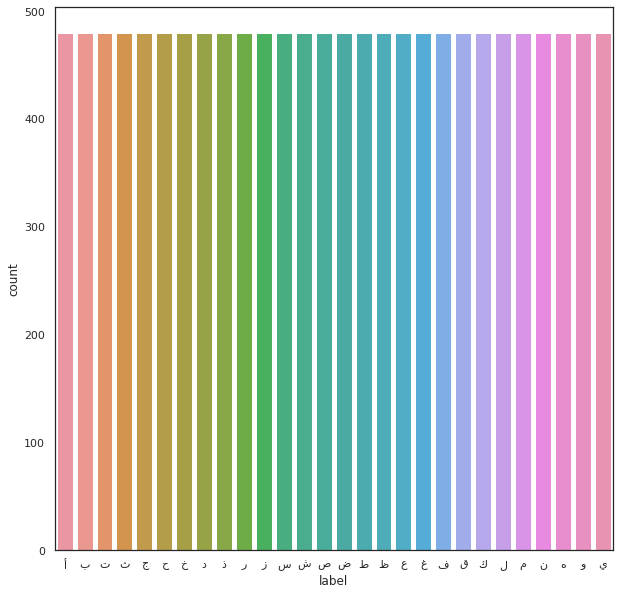

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
g = sns.countplot(data=y_train,x="label")
g.set_xticklabels(arabic_characters);

- We have similar counts for the 28 arabic alphabet.

In [12]:
len(arabic_characters)

28

In [13]:
'''for i in range(25):
    print(y_train['label'][RANDOM_LIST[i]],'\n')
    print(arabic_characters[int(y_train['label'][RANDOM_LIST[i]])-1])'''

"for i in range(25):\n    print(y_train['label'][RANDOM_LIST[i]],'\n')\n    print(arabic_characters[int(y_train['label'][RANDOM_LIST[i]])-1])"

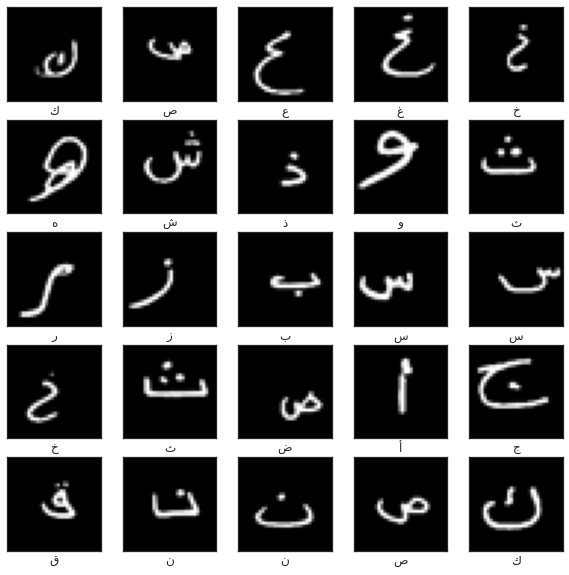

In [14]:
# random list to show 25 char.
RANDOM_LIST = np.random.randint(0, 13440, size=25)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[RANDOM_LIST[i]].reshape(32,32).T,"gray")
    plt.xlabel(arabic_characters[int(y_train['label'][RANDOM_LIST[i]])-1])

plt.show()

## Label encoding

In [15]:
new_label=[]
for i,o in y_train.iteritems():
    new_label.append(o.astype(int)-1)
    #print((o).astype(int))

In [16]:
new_label = new_label[0]

In [17]:
np.shape(new_label)

(13440,)

In [18]:
y_train

,label
0,1
1,1
2,1
3,1
4,1
...,...
13435,28
13436,28
13437,28
13438,28


In [19]:
y_train['label'].shape

(13440,)

In [20]:
y_train['new_label']=new_label

In [21]:
y_train

,label,new_label
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
13435,28,27
13436,28,27
13437,28,27
13438,28,27


In [22]:
new_label=[]
for i,o in y_test.iteritems():
    new_label.append(o.astype(int)-1)

In [23]:
new_label = new_label[0]
y_test['new_label']=new_label

In [24]:
y_test

,label,new_label
0,1,0
1,1,0
2,2,1
3,2,1
4,3,2
...,...,...
3355,26,25
3356,27,26
3357,27,26
3358,28,27


In [25]:
Y_train = y_train['new_label'].values
Y_test = y_test['new_label'].values


In [26]:
# Encode labels to one hot vectors (ex : ب -> [....,0,1,0,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [27]:
print(Y_train.shape, Y_test.shape)


(13440, 28) (3360, 28)


In [28]:
for i in zip(Y_train[0], arabic_characters):
    print(i)

(1.0, 'أ')
(0.0, 'ب')
(0.0, 'ت')
(0.0, 'ث')
(0.0, 'ج')
(0.0, 'ح')
(0.0, 'خ')
(0.0, 'د')
(0.0, 'ذ')
(0.0, 'ر')
(0.0, 'ز')
(0.0, 'س')
(0.0, 'ش')
(0.0, 'ص')
(0.0, 'ض')
(0.0, 'ط')
(0.0, 'ظ')
(0.0, 'ع')
(0.0, 'غ')
(0.0, 'ف')
(0.0, 'ق')
(0.0, 'ك')
(0.0, 'ل')
(0.0, 'م')
(0.0, 'ن')
(0.0, 'ه')
(0.0, 'و')
(0.0, 'ي')


# Modeling & evaluation

In [29]:
# Set the CNN model 

from tensorflow.keras import regularizers

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (32,32,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(4096, activation = "relu",kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)))
model.add(Dropout(0.3))
model.add(Dense(256, activation = "relu",kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)))
model.add(Dropout(0.3))
model.add(Dense(28, activation = "softmax"))

2022-10-30 06:00:13.047718: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 06:00:13.048751: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 06:00:13.237984: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 06:00:13.238930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 06:00:13.239810: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [30]:
# Set the optimizer
optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        3

In [31]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
#Adam(lr=0.001)

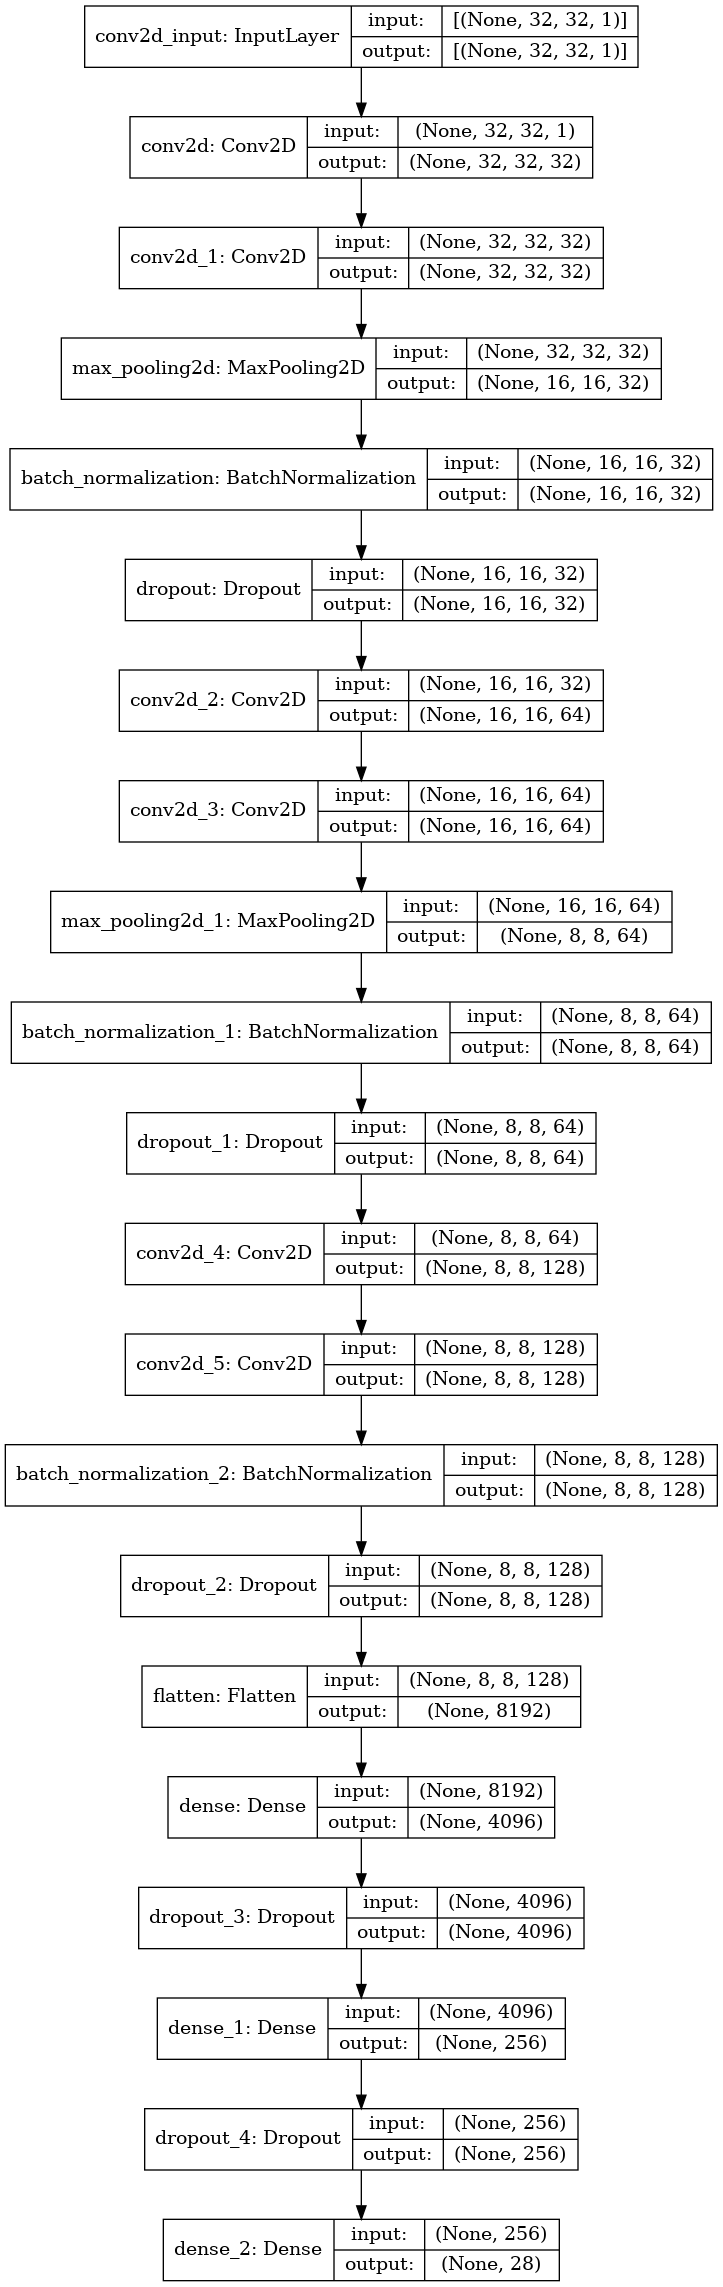

In [32]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [33]:
# Split the train and the validation set for the fitting

X_train, X_val, Y_train, Y_val = train_test_split(x_train, Y_train, test_size = 0.2, random_state=2)

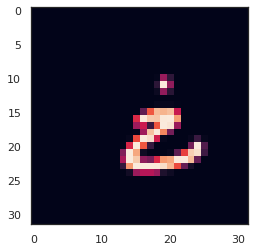

In [34]:
g = plt.imshow(X_train[120][:,:,0].T)


- Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.

- To keep the advantage of the fast computation time with a high LR, i decreased the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).

- With the ReduceLROnPlateau function from Keras.callbacks, i choose to reduce the LR by half if the accuracy is not improved after 3 epochs

In [35]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

###  Data augmentation

- In order to avoid overfitting problem, we need to expand artificially our handwritten characters dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a characters.

- For example, the character is not centered The scale is not the same (some who write with big/small characters) The image is rotated...

In [36]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)


In [37]:
epochs = 50
batch_size = 68


model_checkpoint_callback = ModelCheckpoint(
    filepath="best.h5",
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    mode='max')

es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=20)

# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),steps_per_epoch=X_train.shape[0] // batch_size,
                              verbose = 2,   callbacks=[model_checkpoint_callback,learning_rate_reduction,es])


2022-10-30 06:00:19.888540: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-10-30 06:00:23.416079: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


158/158 - 18s - loss: 7.1388 - accuracy: 0.1962 - val_loss: 9.8640 - val_accuracy: 0.0312

Epoch 00001: val_accuracy improved from -inf to 0.03125, saving model to best.h5
Epoch 2/50
158/158 - 6s - loss: 4.5014 - accuracy: 0.5610 - val_loss: 6.7800 - val_accuracy: 0.1112

Epoch 00002: val_accuracy improved from 0.03125 to 0.11124, saving model to best.h5
Epoch 3/50
158/158 - 5s - loss: 3.0402 - accuracy: 0.7270 - val_loss: 3.8824 - val_accuracy: 0.4542

Epoch 00003: val_accuracy improved from 0.11124 to 0.45424, saving model to best.h5
Epoch 4/50
158/158 - 5s - loss: 2.2665 - accuracy: 0.8017 - val_loss: 2.3407 - val_accuracy: 0.7314

Epoch 00004: val_accuracy improved from 0.45424 to 0.73140, saving model to best.h5
Epoch 5/50
158/158 - 6s - loss: 1.8464 - accuracy: 0.8535 - val_loss: 2.1660 - val_accuracy: 0.7582

Epoch 00005: val_accuracy improved from 0.73140 to 0.75818, saving model to best.h5
Epoch 6/50
158/158 - 5s - loss: 1.6307 - accuracy: 0.8601 - val_loss: 1.3205 - val_accur

### Training and validation curves

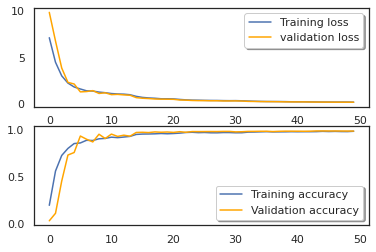

In [38]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='orange', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='orange',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### confusion matrix

<AxesSubplot:>

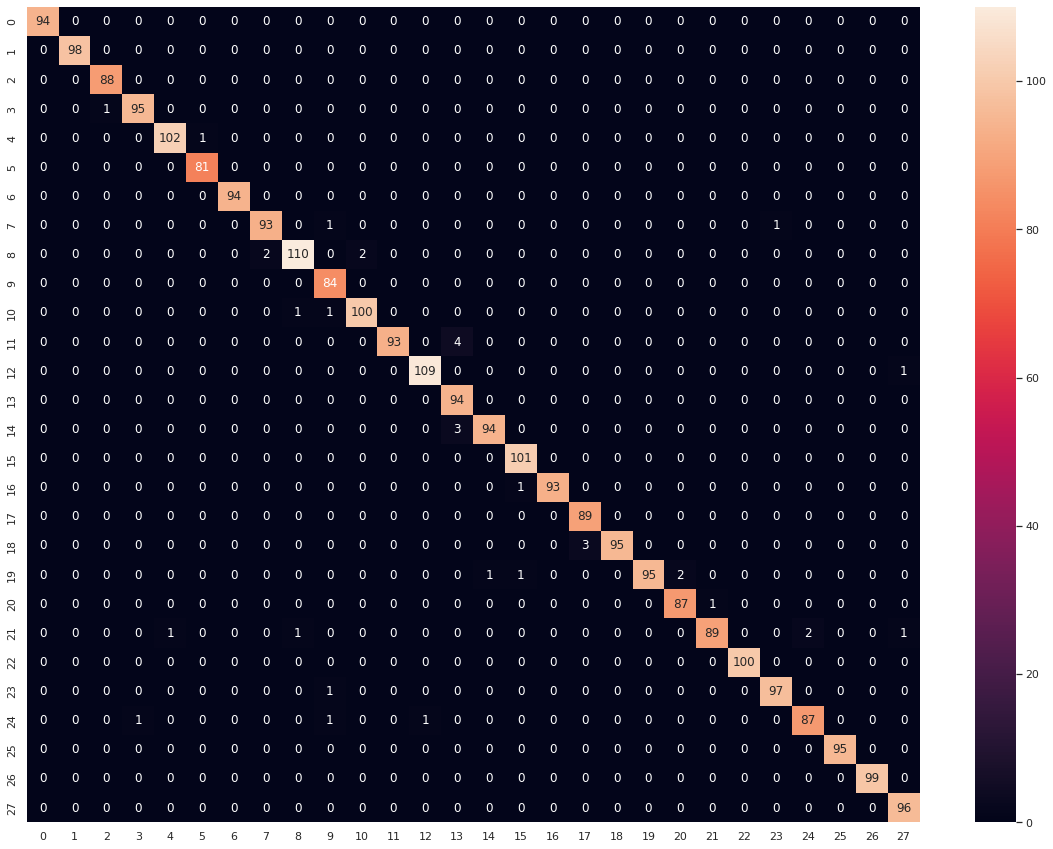

In [39]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(20,15))
# plot the confusion matrix
sns.heatmap(cm, annot=True, fmt="d")

- Here we can see that our CNN performs very well on all characters with few errors

### evalute the model on test set

In [40]:

results = model.predict(x_test)


In [41]:
pred = np.argmax(results,axis = 1) 
true = np.argmax(Y_test,axis = 1) 


In [42]:
cm = confusion_matrix(true, pred)
accuracy = sum(cm[i][i] for i in range(28)) / true.shape[0]
print("accuracy = " + str(accuracy))

accuracy = 0.9839285714285714


<AxesSubplot:>

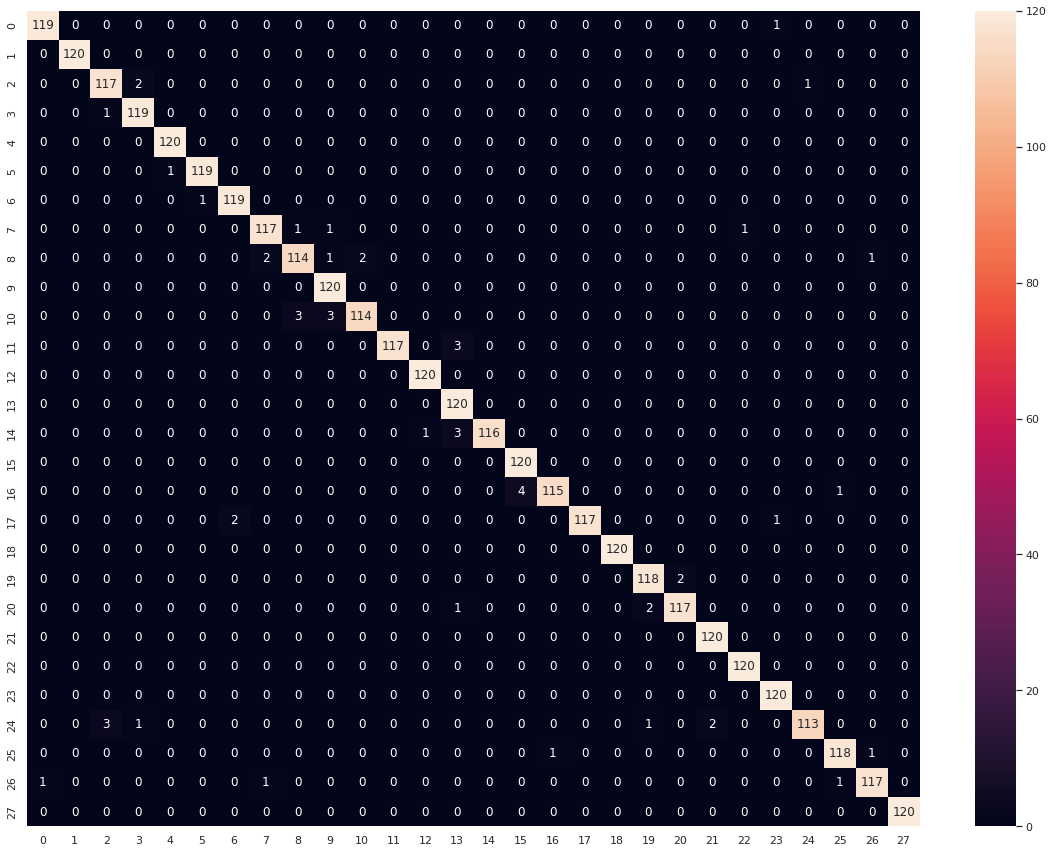

In [43]:
plt.figure(figsize=(20,15))

# plot the confusion matrix
sns.heatmap(cm, annot=True, fmt="d")

- Let's investigate for errors.
- I want to see the most important errors .

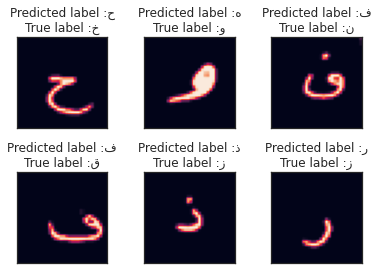

In [44]:
# Errors are difference between predicted labels and true labels
errors = (pred - true != 0)

Y_pred_classes_errors = pred[errors]
Y_pred_errors = results[errors]
Y_true_errors = true[errors]
X_val_errors = x_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((32,32)).T)
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(arabic_characters[pred_errors[error]],arabic_characters[obs_errors[error]]))
            n += 1
            plt.xticks([])
            plt.yticks([])

# Probabilities of the wrong predicted CHARACTERS
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [45]:
model.save("final.h5")